In [1]:
%run 'init.ipynb'
save = get_figsave('1');

## r = 0

In [54]:
a_1, a_2, r, x, y = sp.symbols('a_1, a_2, r, x, y')

xdot = a_1 / (1 + y**r) - x
ydot = a_2 / (1 + x**r) - y

eq_x = sp.solve(xdot.subs(r, 0), x)[0]
eq_y = sp.solve(ydot.subs(r, 0), y)[0]

eq_x, eq_y

## Only one fixed point for 0 < r < 2

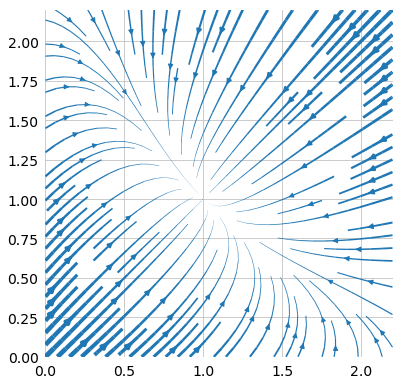

In [3]:
xdot_np = sp.lambdify((x, y, r), xdot.subs(a_1, 2))
ydot_np = sp.lambdify((x, y, r), ydot.subs(a_2, 2))

def get_field(xmax, r=1):
    xgrid, ygrid = np.meshgrid(np.linspace(0, xmax, 200),
                               np.linspace(0, xmax, 200))
    with ignore(RuntimeWarning):
        xdot_grid = xdot_np(xgrid, ygrid, r)
        ydot_grid = ydot_np(xgrid, ygrid, r)
    return xgrid, ygrid, xdot_grid, ydot_grid

field = get_field(2.2, r=1)
fig, ax = streamplot(*field, speed=True)
save(fig, 'streamline_close');

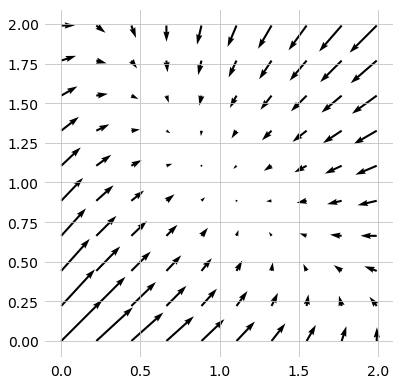

In [4]:
fig, ax = quiver(*field, subsample=20)
save(fig, 'quiver_close');

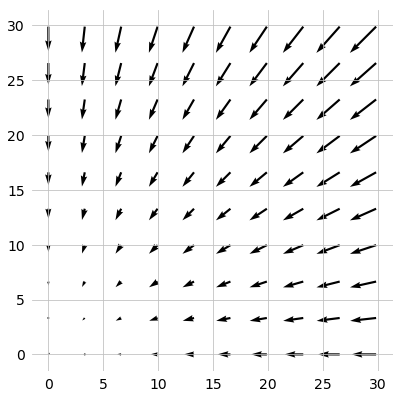

In [5]:
field_large = get_field(33, r=1)
fig, ax = quiver(*field_large, subsample=20)
save(fig, 'quiver_far');

In [6]:
from scipy.integrate import solve_ivp

rr = 1

def f(t, y):
    return (
        xdot_np(y[0], y[1], rr),
        ydot_np(y[0], y[1], rr),
    )

y_0 = (1.2, 1)
t_span = (0, -10)

sol = solve_ivp(f, t_span, y_0)
sol.y

array([[1.20000000e+00, 1.23044738e+00, 1.76651099e+00, 4.51968492e+00,
        1.58019272e+01, 6.05648771e+01, 2.41370047e+02, 9.77997670e+02,
        3.99016629e+03, 7.80910717e+03],
       [1.00000000e+00, 1.01449549e+00, 1.35114210e+00, 3.34422957e+00,
        1.16627081e+01, 4.46970348e+01, 1.78131466e+02, 7.21763770e+02,
        2.94474880e+03, 5.76313298e+03]])

## Stability of (1,1)

In [7]:
from sympy import Matrix

F = Matrix([xdot, ydot])
J = F.jacobian([x, y]).subs(dict(a_1=2, a_2=2, x=1, y=1))

⎡     -r ⎤
⎢-1   ───⎥
⎢      2 ⎥
⎢        ⎥
⎢-r      ⎥
⎢───  -1 ⎥
⎣ 2      ⎦

In [8]:
J.eigenvects()

⎡⎛  r         ⎡⎡1⎤⎤⎞  ⎛r         ⎡⎡-1⎤⎤⎞⎤
⎢⎜- ─ - 1, 1, ⎢⎢ ⎥⎥⎟, ⎜─ - 1, 1, ⎢⎢  ⎥⎥⎟⎥
⎣⎝  2         ⎣⎣1⎦⎦⎠  ⎝2         ⎣⎣1 ⎦⎦⎠⎦

(eigenval, multiplicity, eigenvec)

## r > 2

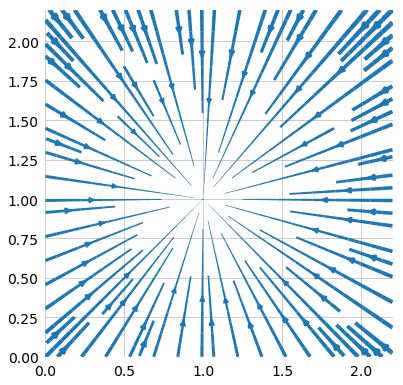

In [9]:
field = get_field(xmax=2.2, r=0)
fig, ax = streamplot(*field, speed=True)
save(fig, 'star')

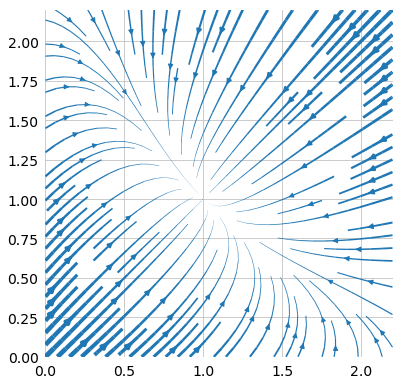

In [10]:
field = get_field(xmax=2.2, r=1)
fig, ax = streamplot(*field, speed=True);

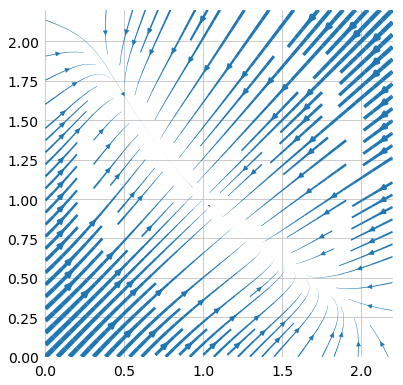

In [11]:
field = get_field(xmax=2.2, r=2)
fig, ax = streamplot(*field, speed=True)
save(fig, 'at_the_fork')

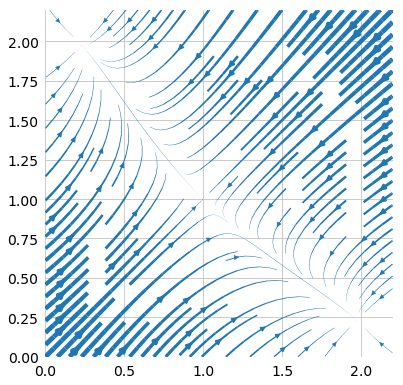

In [12]:
field = get_field(xmax=2.2, r=3)
fig, ax = streamplot(*field, speed=True)
save(fig, 'WTA')

## Bifurcation diagram

In [19]:
xdot_sym = xdot.subs(dict(a_1=2, a_2=2))
ydot_sym = ydot.subs(dict(a_1=2, a_2=2))

F_sym = Matrix([xdot_sym, ydot_sym])

⎡       2   ⎤
⎢-x + ──────⎥
⎢      r    ⎥
⎢     y  + 1⎥
⎢           ⎥
⎢       2   ⎥
⎢-y + ──────⎥
⎢      r    ⎥
⎣     x  + 1⎦

For a given $r$, we want to know where the fixed points are, i.e. (x,y) solution(s).

In [20]:
J_sym = F_sym.jacobian([x, y])

⎡                     r  ⎤
⎢               -2⋅r⋅y   ⎥
⎢    -1       ───────────⎥
⎢                       2⎥
⎢               ⎛ r    ⎞ ⎥
⎢             y⋅⎝y  + 1⎠ ⎥
⎢                        ⎥
⎢        r               ⎥
⎢  -2⋅r⋅x                ⎥
⎢───────────      -1     ⎥
⎢          2             ⎥
⎢  ⎛ r    ⎞              ⎥
⎣x⋅⎝x  + 1⎠              ⎦

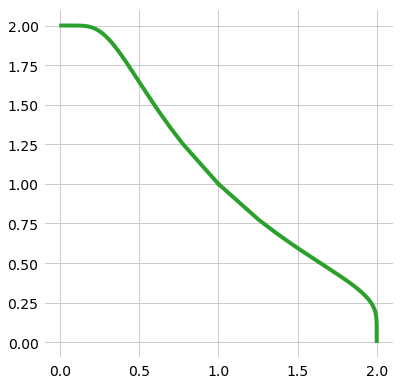

In [127]:
# sp.solve({xdot_sym, ydot_sym}, {x, y})
# Nope, alas

from scipy.optimize import root

F_sym_np = sp.lambdify((x,y,r), F_sym)
J_sym_np = sp.lambdify((x,y,r), J_sym)

f = lambda x, r: F_sym_np(x[0], x[1], r).flatten()
JJ = lambda x, r: J_sym_np(x[0], x[1], r)

arr = np.linspace(2, 8, 200)

fp_left = np.zeros((arr.size, 2))
fp_right = np.zeros((arr.size, 2))

for i, rr in enumerate(arr):
    fp_left[i,:] = root(f, x0=[0.1, 2], args=(rr,), jac=JJ).x
    fp_right[i,:] = root(f, x0=[2, 0.1], args=(rr,), jac=JJ).x
    
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(fp_left[:,0], fp_left[:,1], 'C2-', lw=4)
ax.plot(fp_right[:,0], fp_right[:,1], 'C2-', lw=4)
ax.set_aspect('equal')
save(fig, 'subspace');